In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some visual styles for our plots
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Load the training data
df_train = pd.read_csv('train.csv')

# --- Initial Inspection ---
print("--- Shape of the Training Data ---")
print(df_train.shape)

print("\n--- First 5 Rows ---")
print(df_train.head())

print("\n--- Data Types and Non-Null Counts ---")
df_train.info()

--- Shape of the Training Data ---
(1460, 81)

--- First 5 Rows ---
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   



--- Statistical Summary of SalePrice ---
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


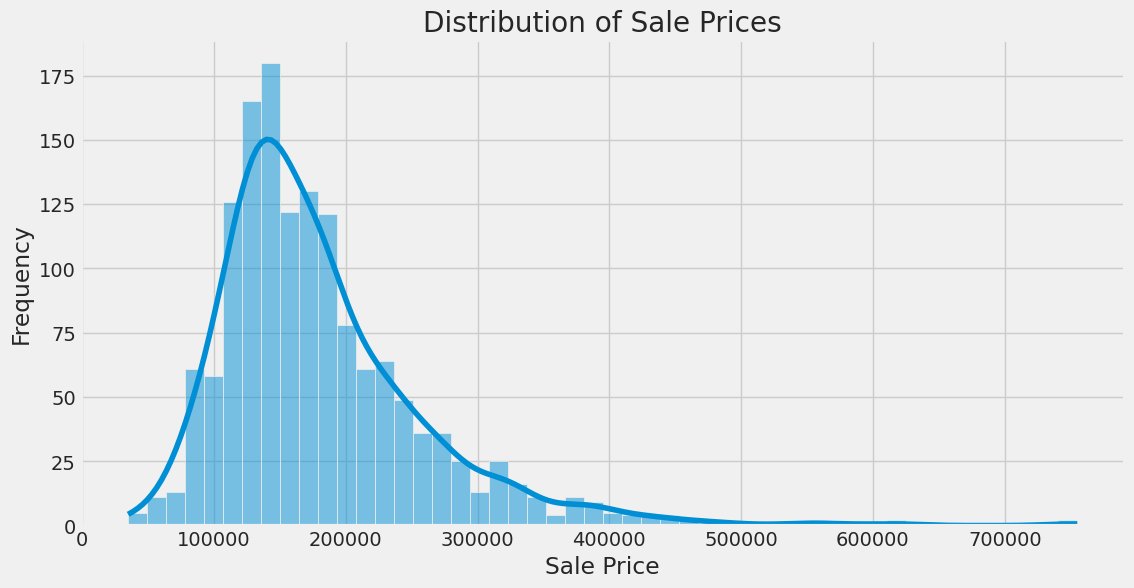

In [2]:
# --- Analyzing SalePrice ---

print("--- Statistical Summary of SalePrice ---")
print(df_train['SalePrice'].describe())

# Create a histogram to see the distribution of SalePrice
plt.figure(figsize=(12, 6))
sns.histplot(df_train['SalePrice'], kde=True, bins=50)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

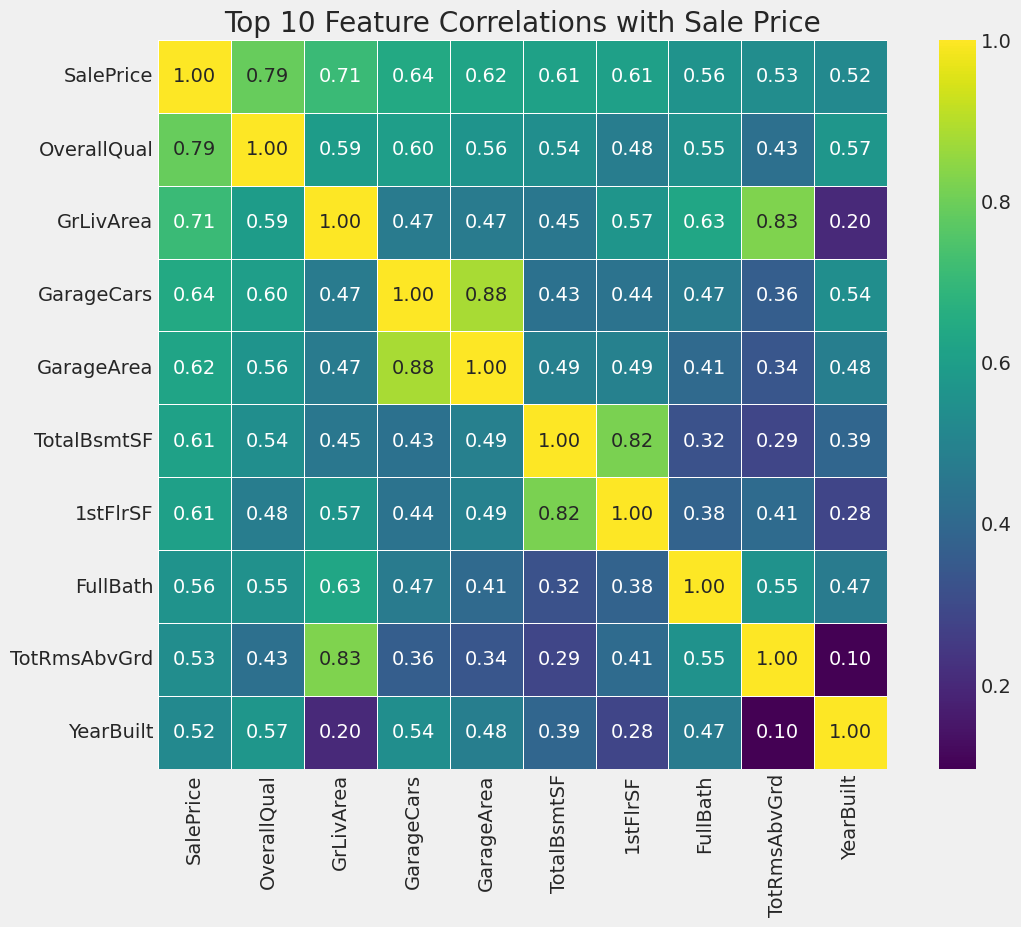

In [3]:
# --- Correlation Analysis ---

# Calculate the correlation matrix for all numerical columns
corrmat = df_train.corr(numeric_only=True)

# Get the top 10 features most correlated with SalePrice
k = 10
top_10_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
top_10_corrmat = df_train[top_10_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(top_10_corrmat, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5, square=True)
plt.title('Top 10 Feature Correlations with Sale Price')
plt.show()

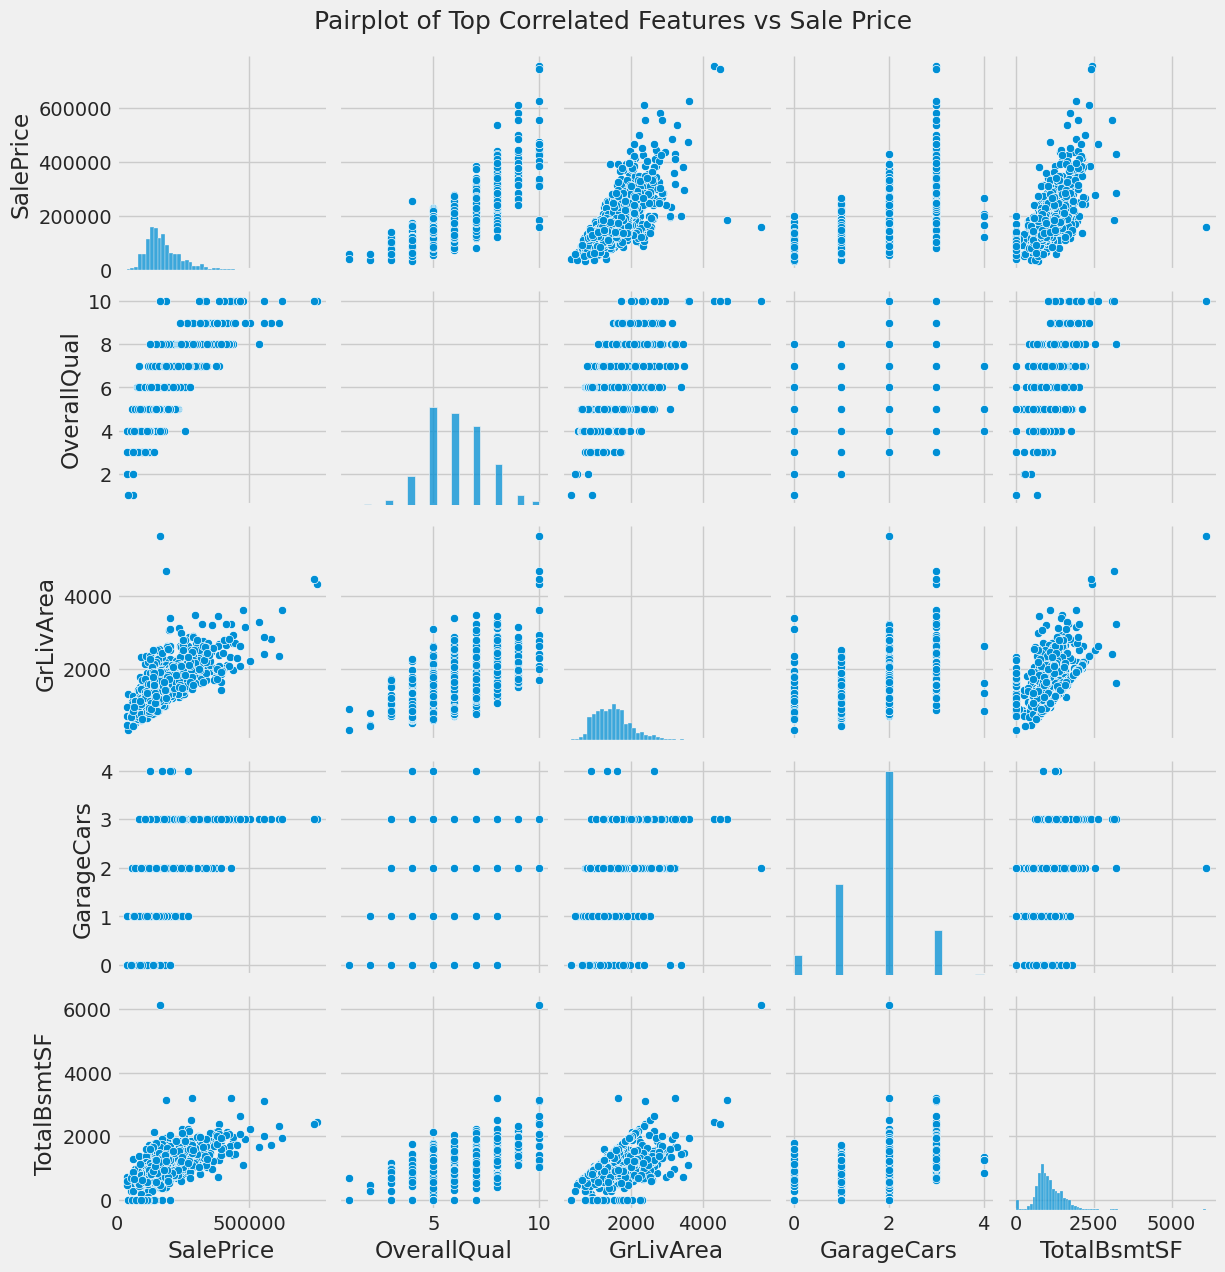

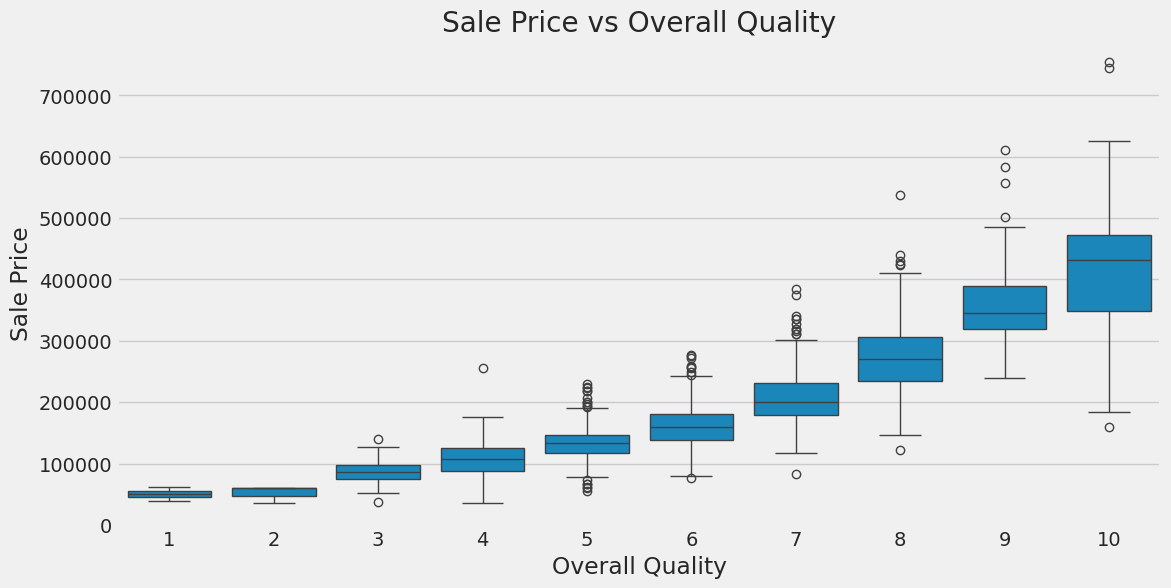

In [4]:
# --- Visualizing Key Feature Relationships ---

# We'll plot the top 4 most correlated numerical features against SalePrice
top_features_to_plot = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']

# Create pairplot
sns.pairplot(df_train[top_features_to_plot], height=2.5)
plt.suptitle('Pairplot of Top Correlated Features vs Sale Price', y=1.02, size=18)
plt.show()


# Let's also create a boxplot for OverallQual vs SalePrice for a clearer view
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)
plt.title('Sale Price vs Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.show()

--- Features with Missing Values and their counts ---
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


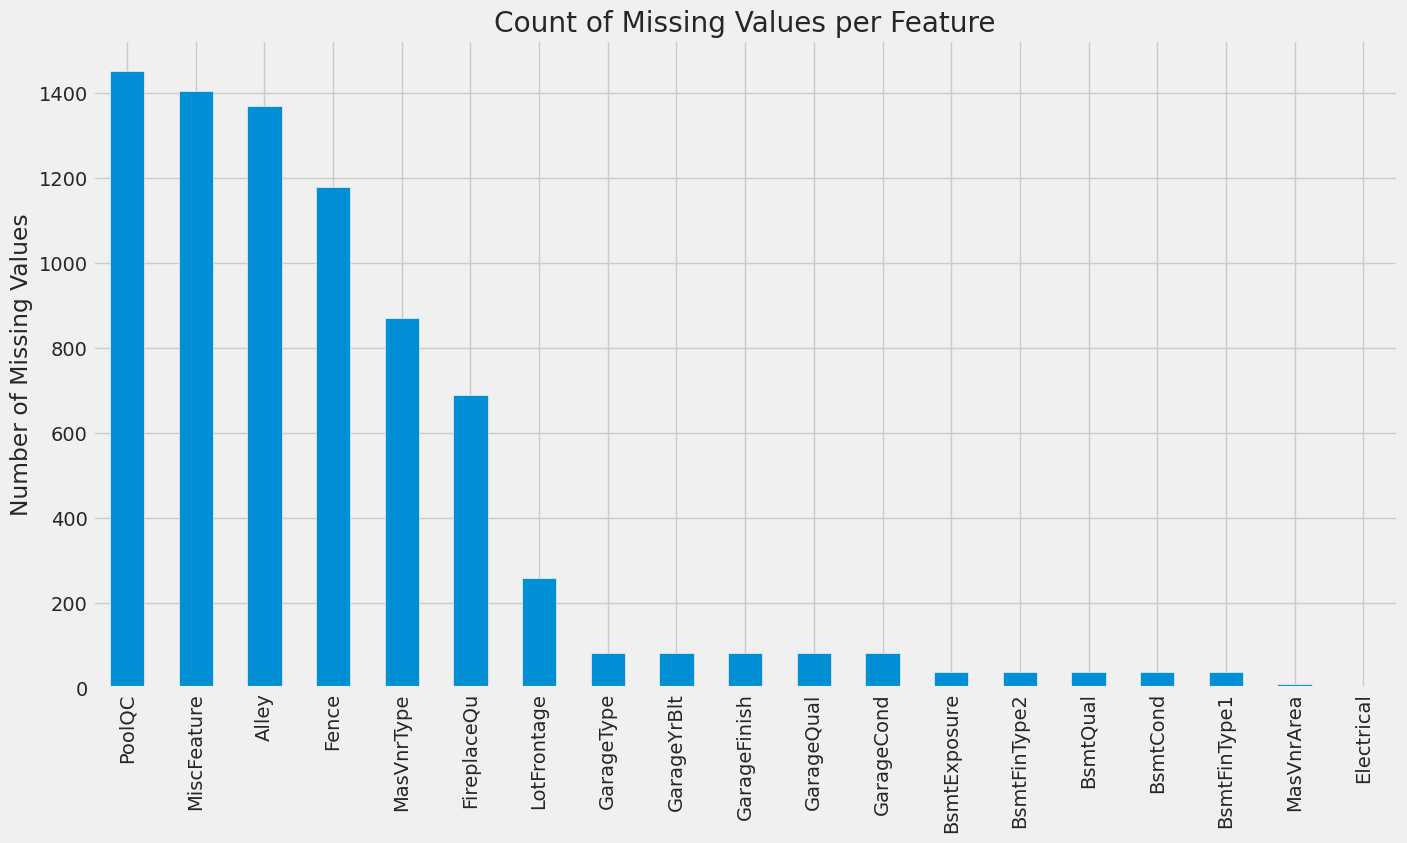

In [5]:
# --- Identifying Missing Values ---

# Calculate the number of missing values for each feature
missing_values = df_train.isnull().sum()

# Filter to only features that have missing values and sort them
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Print the list of features with missing values
print("--- Features with Missing Values and their counts ---")
print(missing_values)

# Create a bar plot to visualize the missing values
plt.figure(figsize=(15, 8))
missing_values.plot.bar()
plt.title('Count of Missing Values per Feature')
plt.ylabel('Number of Missing Values')
plt.show()

In [6]:
# --- Applying Fixes for Missing Values ---

# For these categorical features, NaN means 'None' (the feature doesn't exist)
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
    df_train[col] = df_train[col].fillna('None')

# For these numerical features, NaN means the feature doesn't exist, so we can fill with 0
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']:
    df_train[col] = df_train[col].fillna(0)

# 'LotFrontage' is truly missing data. A good strategy is to fill it with the
# median LotFrontage of all houses in its neighborhood.
df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# For the few remaining categorical NaNs that are likely data entry errors, we'll use the mode (most common value)
df_train['MSZoning'] = df_train['MSZoning'].fillna(df_train['MSZoning'].mode()[0])
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])


# --- Verify that we have no more missing values ---
print("\n--- Checking for Remaining Missing Values ---")
remaining_missing = df_train.isnull().sum().max()
if remaining_missing == 0:
    print("✅ Success! No more missing values in the training data.")
else:
    print(f"❗ Still some missing values to handle. Max missing count: {remaining_missing}")
    print(df_train.isnull().sum()[df_train.isnull().sum() > 0])


--- Checking for Remaining Missing Values ---
✅ Success! No more missing values in the training data.


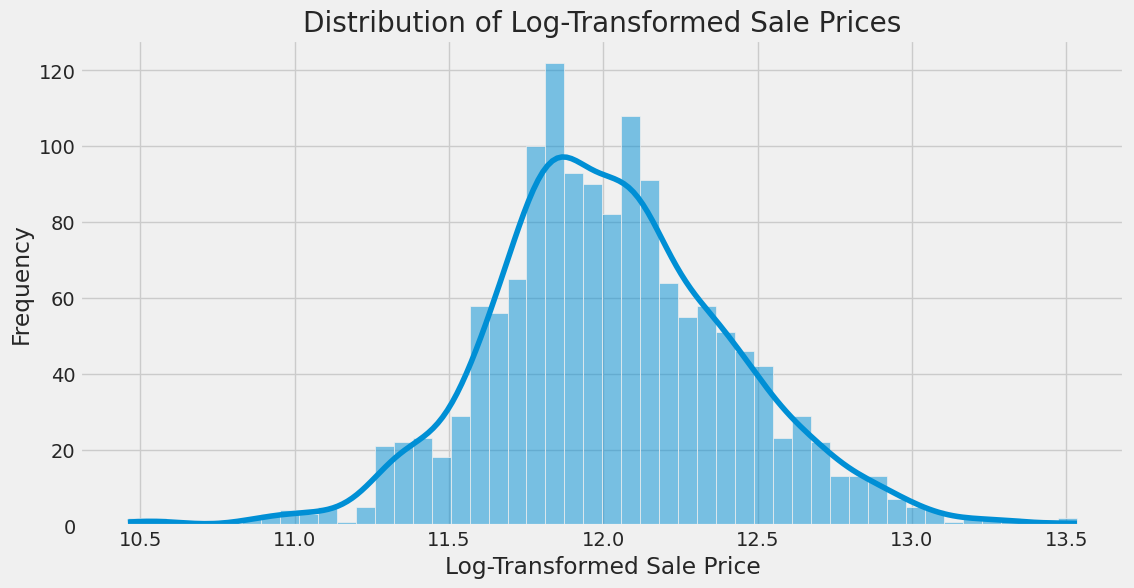


Applied log-transformation to 21 skewed numerical features.

Shape before get_dummies: (1460, 81)
Shape after get_dummies: (2919, 302)

✅ Feature engineering complete.


In [7]:
# --- Feature Engineering ---

# 1. Log-Transforming the Target Variable 'SalePrice'
# We discovered in our EDA that SalePrice is right-skewed.
# A log transformation will make its distribution more normal.
# We use np.log1p which is log(1+x) to handle any potential zero values gracefully.
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# Visualize the transformation
plt.figure(figsize=(12, 6))
sns.histplot(df_train['SalePrice'], kde=True, bins=50)
plt.title('Distribution of Log-Transformed Sale Prices')
plt.xlabel('Log-Transformed Sale Price')
plt.ylabel('Frequency')
plt.show()


# 2. Handling the Remaining Skewed Numerical Features
# We find all numerical columns, check their skewness, and log-transform the highly skewed ones.
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index
skewed_feats = df_train[numeric_feats].apply(lambda x: x.skew()) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df_train[skewed_feats] = np.log1p(df_train[skewed_feats])
print(f"\nApplied log-transformation to {len(skewed_feats)} skewed numerical features.")


# 3. Converting Categorical Features to Numerical using One-Hot Encoding
# Machine learning models can only work with numbers. We need to convert our text
# categories into a numerical format. The get_dummies function does this for us.
print(f"\nShape before get_dummies: {df_train.shape}")

# We'll need the test data for this step soon, so let's load it now
df_test = pd.read_csv('test.csv')

# Combine train and test data to ensure all categories are represented
all_data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))

all_data = pd.get_dummies(all_data)
print(f"Shape after get_dummies: {all_data.shape}")

print("\n✅ Feature engineering complete.")

What This Code Does
Log Transformation: First, it applies a log1p transformation to SalePrice. It then plots a new histogram, where you will see that the distribution now looks much more like a symmetrical "bell curve," which is perfect for our models. It then finds all other numerical features with significant skew and transforms them as well.

One-Hot Encoding: The most important step here is pd.get_dummies(all_data). This function takes all the columns that have text data (like Neighborhood, HouseStyle, etc.) and converts them into a numerical format. It does this by creating new columns for each category. For example, the Neighborhood column will be replaced by many new columns like Neighborhood_NAmes, Neighborhood_CollgCr, etc., filled with 1s and 0s. This is why you'll see the number of columns in our DataFrame increase significantly.

In [8]:
# --- Model Building ---

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# 1. Prepare the data for modeling
# The first 1460 rows are the original training data
X = all_data[:df_train.shape[0]]
# The last rows are the test data, which we'll use later
X_test = all_data[df_train.shape[0]:]
# Our target variable is the log-transformed SalePrice from the original training dataframe
y = df_train['SalePrice']


# 2. Define the models we want to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# 3. Train and evaluate each model using cross-validation
print("--- Model Performance Comparison ---")

# We use Negative Root Mean Squared Error as our scoring metric.
# It's negative because scikit-learn's cross_val_score tries to maximize a score,
# so we maximize the negative error (which is the same as minimizing the error).
scoring = 'neg_root_mean_squared_error'

for name, model in models.items():
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=-1)

    # Calculate the average and standard deviation of the scores
    avg_rmse = -np.mean(scores)
    std_rmse = np.std(scores)

    print(f"{name}:")
    print(f"  Average RMSE: {avg_rmse:.4f}")
    print(f"  Standard Deviation: {std_rmse:.4f}\n")

--- Model Performance Comparison ---
Linear Regression:
  Average RMSE: 0.1444
  Standard Deviation: 0.0239

Ridge Regression:
  Average RMSE: 0.1315
  Standard Deviation: 0.0163

Lasso Regression:
  Average RMSE: 0.2683
  Standard Deviation: 0.0106

Random Forest:
  Average RMSE: 0.1432
  Standard Deviation: 0.0082

Gradient Boosting:
  Average RMSE: 0.1256
  Standard Deviation: 0.0101

XGBoost:
  Average RMSE: 0.1400
  Standard Deviation: 0.0115



In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# --- Hyperparameter Tuning with RandomizedSearchCV ---

# 1. We choose our champion model (let's assume XGBoost)
# Note: If GradientBoostingRegressor was better, you can use that instead.
model = xgb.XGBRegressor(random_state=42)

# 2. Define a "grid" of hyperparameters to search through.
# These are some of the most important settings for XGBoost.
param_grid = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4), # Range is start, width
    'colsample_bytree': uniform(0.6, 0.4)
}

# 3. Set up the Randomized Search with Cross-Validation
# n_iter=100 means it will try 100 different combinations of settings.
# cv=5 means it will use 5-fold cross-validation for each combination.
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1, # This will print progress
    n_jobs=-1, # Use all available CPU cores
    random_state=42
)

# 4. Run the search
print("--- Starting Hyperparameter Tuning (this may take several minutes)... ---")
random_search.fit(X, y)

# 5. Print the best results
print("\n--- Tuning Complete! ---")
print(f"Best RMSE found: {-random_search.best_score_:.4f}")
print("\nBest Hyperparameters found:")
print(random_search.best_params_)

--- Starting Hyperparameter Tuning (this may take several minutes)... ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Tuning Complete! ---
Best RMSE found: 0.1202

Best Hyperparameters found:
{'colsample_bytree': np.float64(0.718509402281633), 'learning_rate': np.float64(0.05958008171890075), 'max_depth': 3, 'n_estimators': 938, 'subsample': np.float64(0.7693605922825478)}


In [10]:
# --- Step 6: Final Prediction & Submission ---

print("--- Preparing Final Model and Making Predictions ---")

# 1. Our final model is the best one found by RandomizedSearchCV
# It already has the best hyperparameters set.
final_model = random_search.best_estimator_

# 2. Fit the final model on ALL the training data.
# We used cross-validation for tuning, but for the final prediction,
# we should use all the data we have to make the model as knowledgeable as possible.
print("Fitting the final model on all training data...")
final_model.fit(X, y)

# 3. Ensure the test data has the same columns as the training data
# This handles cases where a category in the training set might not be in the test set after one-hot encoding.
missing_cols = set(X.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
# Ensure the order of columns is the same, which is critical for the model
X_test = X_test[X.columns]

# Just in case, fill any remaining NaNs in the test set with the median of the training data
X_test.fillna(X.median(), inplace=True)


# 4. Make predictions on the processed test data
print("Making predictions on the test set...")
predictions_log = final_model.predict(X_test)

# 5. Transform predictions back from the log scale to the original dollar scale.
# We used np.log1p to transform the prices, so we use np.expm1 to reverse it.
predictions = np.expm1(predictions_log)
print("Predictions transformed back to original dollar scale.")


# 6. Create the submission DataFrame in the specified Kaggle format
submission = pd.DataFrame()
submission['Id'] = df_test['Id']
submission['SalePrice'] = predictions

# 7. Save the submission file to CSV
submission.to_csv('submission.csv', index=False)


print("\n✅ Success! Your submission file 'submission.csv' has been created.")
print("You can now download it from the Colab file browser and submit it to the Kaggle competition.")

print("\n--- Submission File Preview ---")
print(submission.head())

--- Preparing Final Model and Making Predictions ---
Fitting the final model on all training data...
Making predictions on the test set...
Predictions transformed back to original dollar scale.

✅ Success! Your submission file 'submission.csv' has been created.
You can now download it from the Colab file browser and submit it to the Kaggle competition.

--- Submission File Preview ---
     Id      SalePrice
0  1461  188466.859375
1  1462  207423.406250
2  1463  251213.875000
3  1464  289023.968750
4  1465  312352.468750
